In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
!find ../ data.csv

../
../.ipynb_checkpoints
../.ipynb_checkpoints/trial_kaggle_house_prices-checkpoint.ipynb
../.ipynb_checkpoints/Kickstarter-checkpoint.ipynb
../House Prices
../House Prices/test.csv
../House Prices/__init__.py
../House Prices/trial_kaggle_house_prices.ipynb
../House Prices/data_description.txt
../House Prices/structured.py
../House Prices/train.csv
../House Prices/sample_submission.csv
../Kickstarter
../Kickstarter/Kickstarter.ipynb
../Kickstarter/imports.py
../Kickstarter/data.csv
../Kickstarter/structured.py
data.csv


In [3]:
df = pd.read_csv('../Kickstarter/data.csv')

In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
df.shape

(378661, 15)

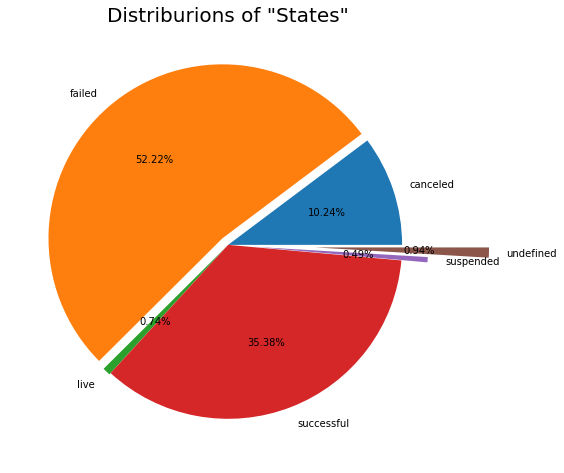

In [6]:
states = df.groupby(['state']).size()
f, ax = plt.subplots(figsize=(10, 8))
explode = (0, 0.05, 0.01, 0, 0.15, 0.5)
plt.subplot(aspect=True)
plt.pie(states, labels=states.index.values, autopct='%0.2f%%', explode=explode)
plt.title('Distriburions of "States"', fontsize=20);

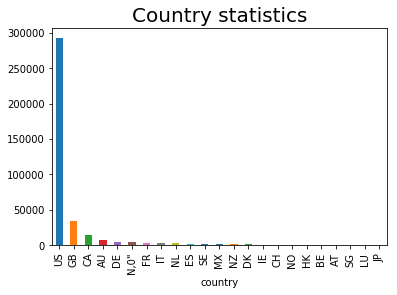

In [7]:
plt.title('Country statistics', fontsize=20)
df.groupby('country').size().sort_values(ascending=False).plot(kind='bar');

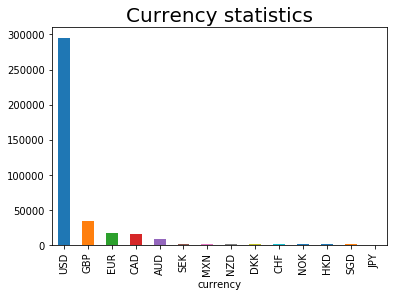

In [8]:
plt.title('Currency statistics', fontsize=20)
df.groupby('currency').size().sort_values(ascending=False).plot(kind='bar');

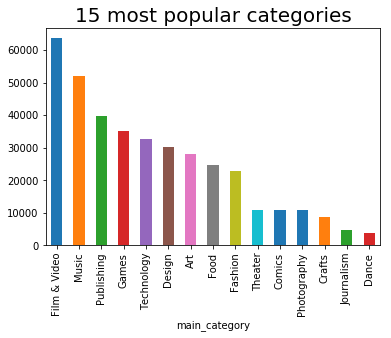

In [9]:
plt.title('15 most popular categories', fontsize=20)
df.groupby('main_category').size().sort_values(ascending=False)[:15].plot(kind='bar');

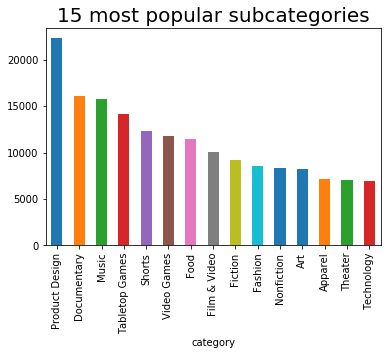

In [10]:
plt.title('15 most popular subcategories', fontsize=20)
df.groupby('category').size().sort_values(ascending=False)[:15].plot(kind='bar');

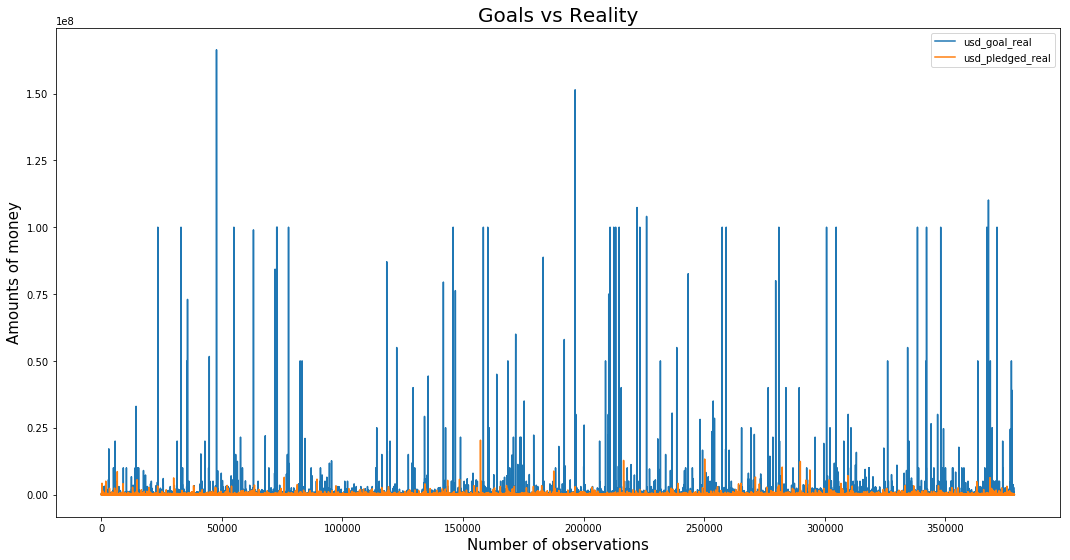

In [11]:
df[['usd_goal_real','usd_pledged_real']].plot(figsize=(18,9));

plt.xlabel('Number of observations', fontsize=15);
plt.ylabel('Amounts of money', fontsize=15);
plt.title('Goals vs Reality', fontsize=20);

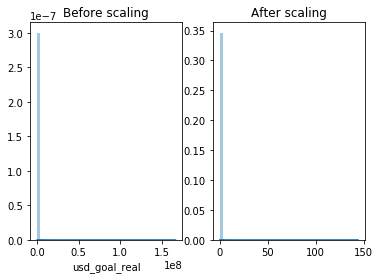

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Scaling 'usd_goal_real'
unscaled_1 = df['usd_goal_real']
scaled_1 = StandardScaler().fit_transform(df[['usd_goal_real']])

fig, ax = plt.subplots(1, 2);
sns.distplot(unscaled_1, ax=ax[0]);
ax[0].set_title('Before scaling');
sns.distplot(scaled_1, ax=ax[1]);
ax[1].set_title('After scaling');

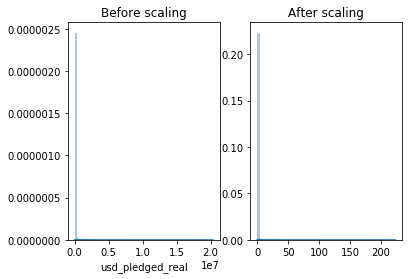

In [13]:
# Scaling 'usd_pledged_real'
unscaled_2 = df['usd_pledged_real']
scaled_2 = StandardScaler().fit_transform(df[['usd_pledged_real']])

fig, ax = plt.subplots(1, 2);
sns.distplot(unscaled_2, ax=ax[0]);
ax[0].set_title('Before scaling');
sns.distplot(scaled_2, ax=ax[1]);
ax[1].set_title('After scaling');

In [14]:
df['usd_goal_real'] = scaled_1
df['usd_pledged_real'] = scaled_2

In [15]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,-0.099578,-0.038094
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,-0.072966,-0.013404
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,-0.097160,-0.000394
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,-0.099567,-0.035088
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,-0.085475,-0.022511


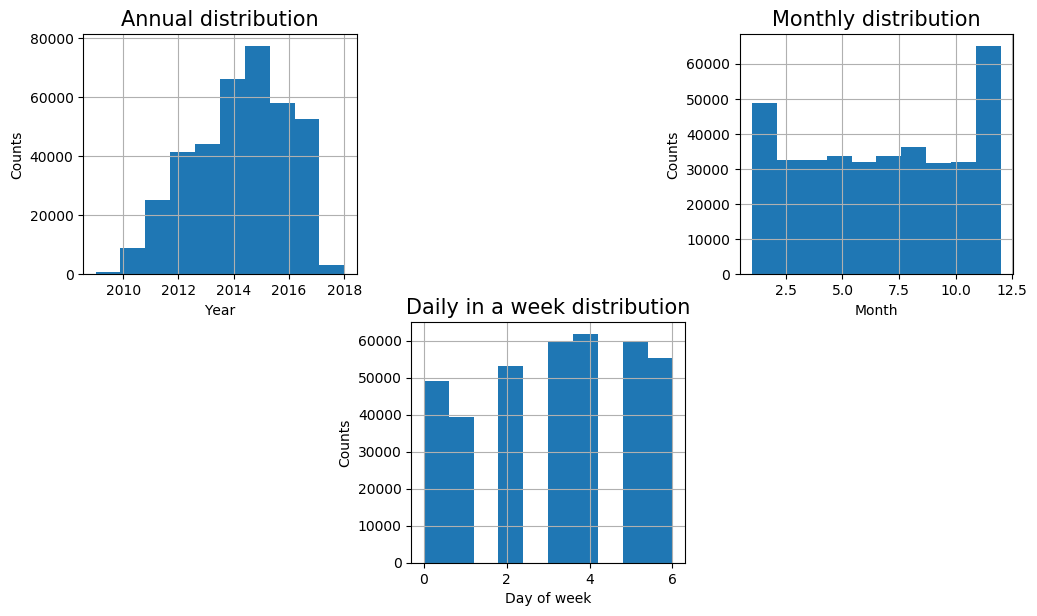

In [16]:
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])


fig = plt.figure(figsize=(12,7), dpi=100)

plt.subplot(231)
df['deadline'].dt.year.hist()
plt.xlabel('Year', fontsize=10);
plt.ylabel('Counts', fontsize=10);
plt.title('Annual distribution', fontsize=15);

plt.subplot(233)
df['deadline'].dt.month.hist()
plt.xlabel('Month', fontsize=10);
plt.ylabel('Counts', fontsize=10);
plt.title('Monthly distribution', fontsize=15);

plt.subplot(235)
df['deadline'].dt.dayofweek.hist()
plt.xlabel('Day of week', fontsize=10);
plt.ylabel('Counts', fontsize=10);
plt.title('Daily in a week distribution', fontsize=15);

In [17]:
#Сохраняем дата фрейм с целевыми значениями
df = df[(df['state'] == 'failed') | (df['state'] == 'successful')]
#Создаем новый столбец, содержащий длину названий проектов
df['title_length'] = df['name'].str.len()
#Создаем новый столбец, который отражает длительность проектов по времени
df['duration_in_days'] = (df['deadline'].dt.date - df['launched'].dt.date).dt.days
df = df.astype({'deadline': 'int', 'launched': 'int'})
#Дропаем строки со статусом 'canceled', а также эквивалент usd_pledged_real - usd pledged и прочее ненужные колонки
df.drop('usd pledged', axis=1, inplace=True)
df.drop('ID', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('pledged', axis=1, inplace=True)
df.drop('goal', axis=1, inplace=True)

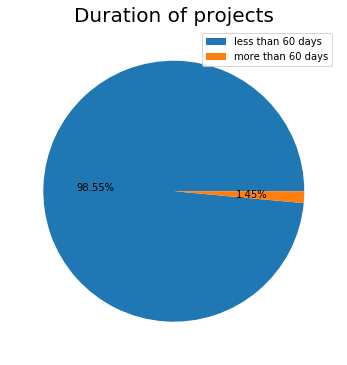

In [18]:
duration_of_projects = df.groupby(df['duration_in_days'] > 60).size()
f, ax = plt.subplots(figsize=(8, 6))
plt.pie(duration_of_projects, autopct='%0.2f%%')
plt.title('Duration of projects', fontsize=20);
plt.legend(['less than 60 days', 'more than 60 days'])

plt.show()

In [19]:
#Data Cleaning : Missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (100 * df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1)
missing_data.rename(columns={0: 'Total amount', 1: 'Percentage(%)'}, inplace=True)

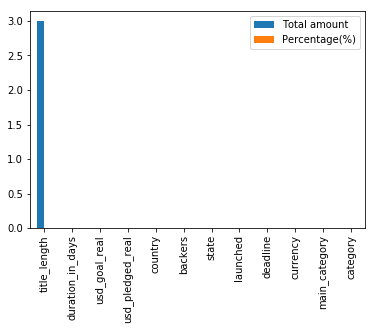

In [20]:
missing_data.plot(kind='bar');

In [21]:
#заполняем пропущенные значения
df['title_length'] = df['title_length'].fillna(0)

In [22]:
df.head()

,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,title_length,duration_in_days
0,Poetry,Publishing,GBP,1444348800000000000,1439295148000000000,failed,0,GB,-0.099578,-0.038094,31.0,59
1,Narrative Film,Film & Video,USD,1509494400000000000,1504327437000000000,failed,15,US,-0.072966,-0.013404,45.0,60
2,Narrative Film,Film & Video,USD,1361836800000000000,1357950050000000000,failed,3,US,-0.097160,-0.000394,14.0,45
3,Music,Music,USD,1334534400000000000,1331954651000000000,failed,1,US,-0.099567,-0.035088,49.0,30
5,Restaurants,Food,USD,1459468800000000000,1456493907000000000,successful,224,US,0.476141,0.003943,20.0,35


In [23]:
converter = {'failed': 0, 'successful': 1}

In [24]:
df['state'] = df['state'].map(converter)

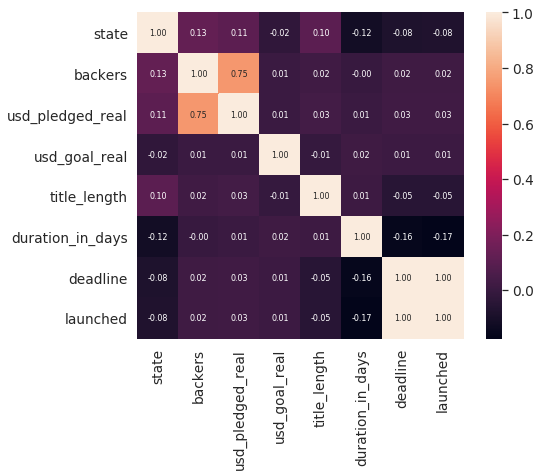

In [25]:
k = 15
corrmat = abs(df.corr(method='spearman'))
cols = corrmat.nlargest(k, 'state').index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [26]:
categorical_features = df.select_dtypes(include='object').columns
numerical_features = df.select_dtypes(exclude='object').columns

print(f'Categorical_features: {len(categorical_features)}')
print(f'Numerical_features: {len(numerical_features)}')

Categorical_features: 4
Numerical_features: 8


In [27]:
for i in categorical_features:
    df = pd.get_dummies(df, columns = [i])

In [28]:
df.head()

,deadline,launched,state,backers,usd_pledged_real,usd_goal_real,title_length,duration_in_days,category_3D Printing,category_Academic,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1444348800000000000,1439295148000000000,0,0,-0.099578,-0.038094,31.0,59,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1509494400000000000,1504327437000000000,0,15,-0.072966,-0.013404,45.0,60,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1361836800000000000,1357950050000000000,0,3,-0.097160,-0.000394,14.0,45,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1334534400000000000,1331954651000000000,0,1,-0.099567,-0.035088,49.0,30,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1459468800000000000,1456493907000000000,1,224,0.476141,0.003943,20.0,35,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
#выделяем целевое значение
y = df['state']
X = df.drop('state', axis=1)

### Logistic regression

In [32]:
df_lr = df.copy()

In [33]:
df_lr.drop('deadline', axis=1, inplace=True)
df_lr.drop('launched', axis=1, inplace=True)

In [34]:
X_lr = df_lr.drop('state', axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_lr, y, test_size=0.3)

In [36]:
scores = []
Cs = np.logspace(-3, 1, 10)
for C in Cs:
    lr = LogisticRegression(C=C).fit(X_train, y_train)
    scores.append(round(lr.score(X_test, y_test)*100, 2))

In [37]:
print(scores)

[83.28, 83.66, 84.09, 84.42, 85.04, 86.09, 87.1, 89.1, 90.73, 92.12]


In [38]:
Cs[np.argmax(scores)]

10.0

In [39]:
%%time
lr = LogisticRegression(C=Cs[np.argmax(scores)])
lr.fit(X_train, y_train)
print(f"Model's accuracy is {round(lr.score(X_test, y_test)*100, 2)}")

Model's accuracy is 92.12
CPU times: user 18.3 s, sys: 278 ms, total: 18.6 s
Wall time: 18.6 s


In [40]:
pred_y = lr.predict(X_test)

pd.crosstab(pred_y, y_test)

state,0,1
row_0,,
0,57131,5680
1,2157,34535


In [41]:
cv_scores = cross_val_score(lr, X_train, y_train, cv=10, \
                            scoring='accuracy', n_jobs=-1)

In [42]:
cv_scores, cv_scores.mean()

(array([0.90180456, 0.92061851, 0.89378473, 0.9034759 , 0.88788388,
        0.88650558, 0.9114442 , 0.89145884, 0.88486885, 0.90821381]),
 0.8990058853033845)

In [43]:
print(f'Признак с наибольшим импактом для успеха проекта: {X_train.iloc[:, np.argmax(lr.coef_[0])].name}')
print(f'Признак с наибольшем импактом для провала проекта: {X_train.iloc[:, np.argmin(lr.coef_[0])].name}')

Признак с наибольшим импактом для успеха проекта: usd_pledged_real
Признак с наибольшем импактом для провала проекта: usd_goal_real


### Применяем PCA

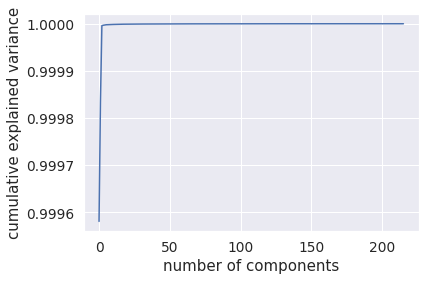

In [44]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [45]:
pca = PCA(n_components=5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Original shape:", X_train.shape)
print("Transformed shape:", X_train_pca.shape)

Original shape: (232172, 216)
Transformed shape: (232172, 5)


In [46]:
%%time
lr = LogisticRegression(C=Cs[np.argmax(scores)])
lr.fit(X_train_pca, y_train)
print(f"Model's accuracy is {round(lr.score(X_test_pca, y_test)*100, 2)}")

Model's accuracy is 85.41
CPU times: user 1.45 s, sys: 125 ms, total: 1.58 s
Wall time: 1.46 s


In [47]:
print(
    'Процент общей дисперсии в наборе данных:\n',
    pca.explained_variance_ratio_)

Процент общей дисперсии в наборе данных:
 [9.99581086e-01 2.53531922e-04 1.61251567e-04 9.71689999e-07
 5.60782141e-07]


### Naive Bayes Classification

In [48]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB(priors=None)

In [49]:
print(accuracy_score(model.predict(X_test), y_test))

0.6407846999587952


### DecisionTree

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [51]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=23)

tree_params = {'max_depth': list(range(1, 11))}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=23,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

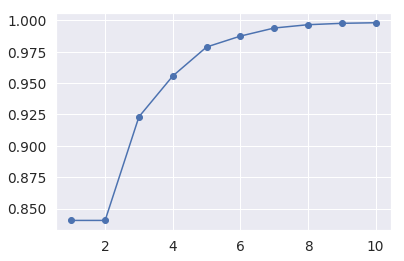

In [52]:
plt.plot(tree_params['max_depth'], tree_grid.cv_results_['mean_test_score'], marker='o');

In [55]:
tree_grid.best_params_

{'max_depth': 10}

In [56]:
tree_grid.score(X_test, y_test)

0.9980000602996895

### Random Forest

In [61]:
param_grid = {
    'max_features': [None, 0.5, 'sqrt'],
    'min_samples_leaf': [3, 4, 5]
}

In [62]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=3, n_jobs=-1)

In [97]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 5min 47s, sys: 2.58 s, total: 5min 50s
Wall time: 34min 39s


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 0.5, 'sqrt'], 'min_samples_leaf': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
grid_search.best_params_

{'max_features': None, 'min_samples_leaf': 3}

In [103]:
best_est = grid_search.best_estimator_

In [113]:
best_est.score(X_test, y_test)

0.9995075525361045

In [104]:
feature_importances = pd.DataFrame(best_est.feature_importances_, \
                                   index = X_train.columns, \
                                   columns=['importance']).sort_values('importance', \
                                                                       ascending=False)

In [105]:
feature_importances[:10]

,importance
backers,0.473320
usd_pledged_real,0.283378
usd_goal_real,0.242593
title_length,0.000100
deadline,0.000094
launched,0.000092
duration_in_days,0.000081
category_Product Design,0.000030
main_category_Technology,0.000014
main_category_Design,0.000013


In [123]:
X_new = X[to_keep]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3)

In [125]:
rf = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=3, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

print(f'general_score: {round(rf.score(X_test, y_test) * 100, 2)}')
print(f'oob_score: {round(rf.oob_score_ * 100, 2)}')

general_score: 99.93
oob_score: 99.93


In [65]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True).fit(X_train, y_train)

In [66]:
rf.score(X_test, y_test)

0.984412530275469

In [67]:
feature_importances = pd.DataFrame(rf.feature_importances_, \
                                   index = X_train.columns, \
                                   columns=['importance']).sort_values('importance', \
                                                                       ascending=False)

In [68]:
feature_importances[:10]

,importance
usd_pledged_real,0.338980
backers,0.322217
usd_goal_real,0.168672
deadline,0.027416
launched,0.026230
duration_in_days,0.023904
title_length,0.022652
main_category_Music,0.003842
main_category_Technology,0.003320
category_Tabletop Games,0.002999


### SVM

In [32]:
from sklearn.svm import SVC
model = SVC()

In [ ]:
model.fit(X_train, y_train)